In [59]:
# Run this cell in Colab (or skip if packages already installed)
!pip install -q scikit-learn xgboost shap gradio pandas matplotlib seaborn joblib imbalanced-learn

In [37]:
# Imports
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve,
accuracy_score, precision_score, recall_score, f1_score)
import xgboost as xgb
import joblib
import shap
from imblearn.over_sampling import SMOTE
sns.set(style='whitegrid')


print('Libraries loaded')

Libraries loaded


In [38]:
DATA_PATH = '/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv'
# If running locally, change DATA_PATH to the local CSV path


df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [40]:
# Drop columns that are identifiers or constant
drop_cols = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)


# Create binary target
if 'Attrition' in df.columns:
    df['Attrition_flag'] = df['Attrition'].map({'Yes':1, 'No':0})
else:
    raise ValueError('Attrition column not found')


# Quick type correction
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()


# Remove target from features
if 'Attrition_flag' in num_cols:
    num_cols.remove('Attrition_flag')


print('Numerical cols:', len(num_cols), 'Categorical cols:', len(cat_cols))

Numerical cols: 23 Categorical cols: 8


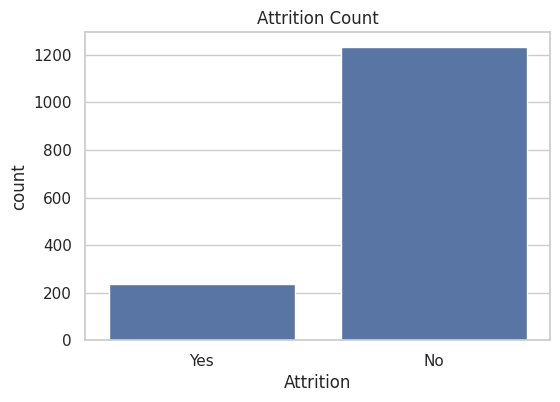

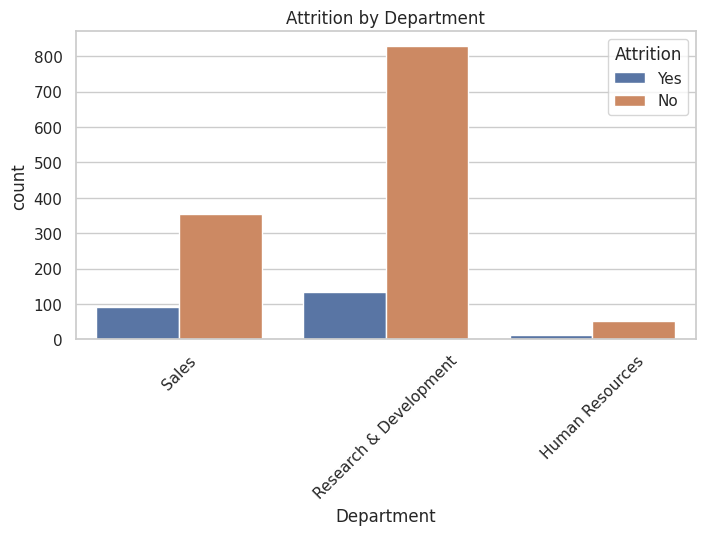

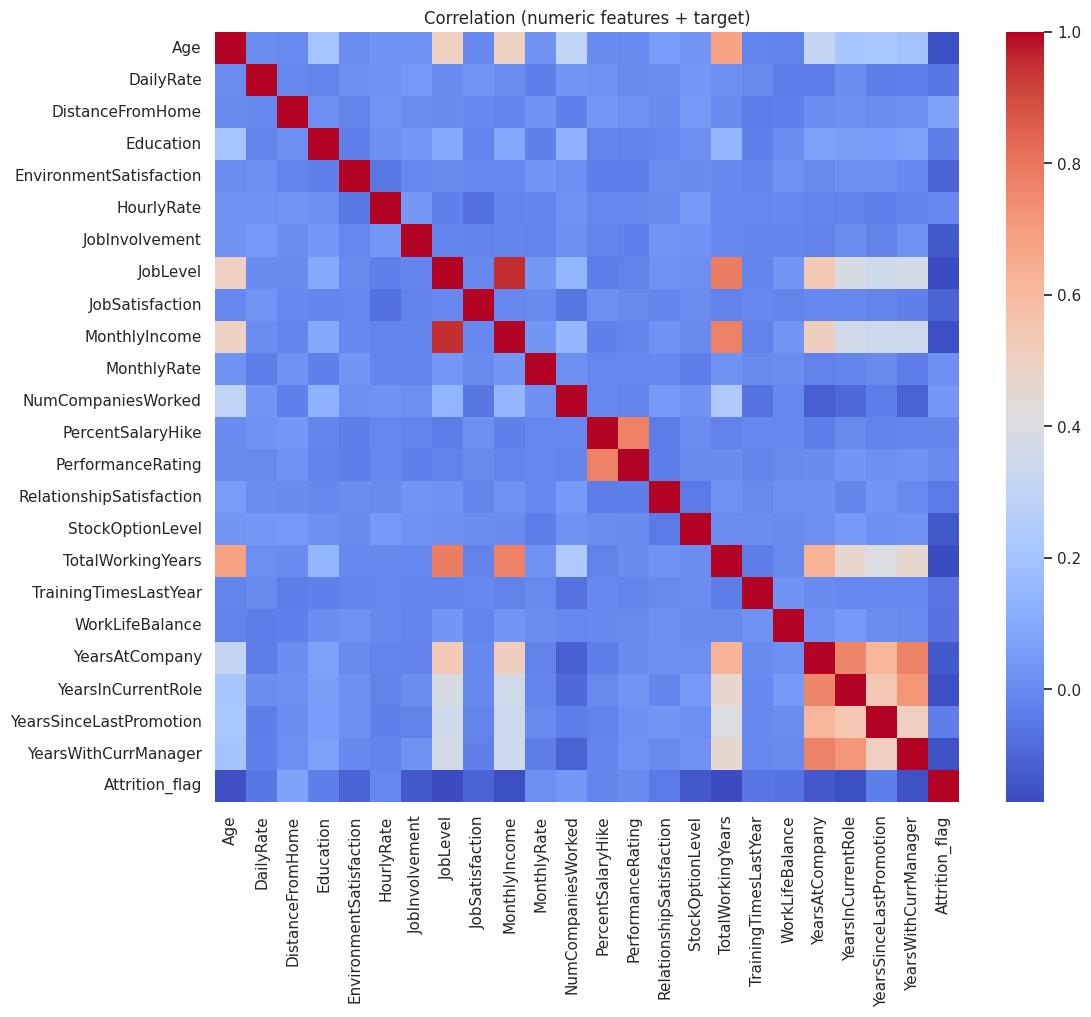

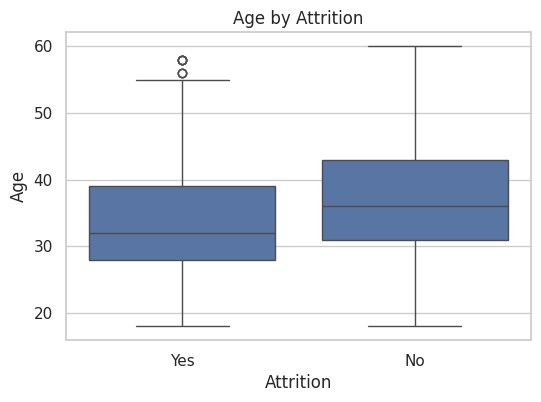

In [41]:
# Attrition distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Count')
plt.show()


# Attrition by Department
plt.figure(figsize=(8,4))
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title('Attrition by Department')
plt.xticks(rotation=45)
plt.show()


# Correlation heatmap for numeric variables
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols + ['Attrition_flag']].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation (numeric features + target)')
plt.show()


# Boxplot Age vs Attrition
plt.figure(figsize=(6,4))
sns.boxplot(x='Attrition', y='Age', data=df)
plt.title('Age by Attrition')
plt.show()

In [43]:
# Define feature lists
features = [c for c in df.columns if c not in ['Attrition', 'Attrition_flag']]
cat_features = [c for c in features if df[c].dtype == 'object']
num_features = [c for c in features if df[c].dtype in [np.int64, np.float64]]


# Pipelines
numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
('num', numeric_transformer, num_features),
('cat', categorical_transformer, cat_features)
])


X = df[features].copy()
y = df['Attrition_flag'].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes', X_train.shape, X_test.shape)

Train/Test shapes (1176, 30) (294, 30)


In [44]:
# Fit preprocessor on training data then transform for SMOTE
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)


print('Preprocessed shapes', X_train_pre.shape, X_test_pre.shape)


# SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_pre, y_train)
print('After SMOTE:', X_res.shape, y_res.sum(), 'positives')

Preprocessed shapes (1176, 51) (294, 51)
After SMOTE: (1972, 51) 986 positives


In [45]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_res, y_res)


y_pred_lr = lr.predict(X_test_pre)
y_proba_lr = lr.predict_proba(X_test_pre)[:,1]


print('Logistic Regression ROC AUC:', roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression ROC AUC: 0.7957619088638127
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       247
           1       0.36      0.57      0.44        47

    accuracy                           0.77       294
   macro avg       0.63      0.69      0.65       294
weighted avg       0.82      0.77      0.79       294



In [46]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_res, y_res)


y_pred_rf = rf.predict(X_test_pre)
y_proba_rf = rf.predict_proba(X_test_pre)[:,1]


print('Random Forest ROC AUC:', roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest ROC AUC: 0.8022654836764579
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       247
           1       0.57      0.26      0.35        47

    accuracy                           0.85       294
   macro avg       0.72      0.61      0.63       294
weighted avg       0.82      0.85      0.83       294



In [47]:
xgb_clf = xgb.XGBClassifier(
n_estimators=200,
max_depth=4,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
use_label_encoder=False,
eval_metric='logloss',
random_state=42
)


xgb_clf.fit(X_res, y_res)


y_pred_xgb = xgb_clf.predict(X_test_pre)
y_proba_xgb = xgb_clf.predict_proba(X_test_pre)[:,1]


print('XGBoost ROC AUC:', roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost ROC AUC: 0.8040313549832027
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.71      0.32      0.44        47

    accuracy                           0.87       294
   macro avg       0.80      0.65      0.68       294
weighted avg       0.86      0.87      0.85       294



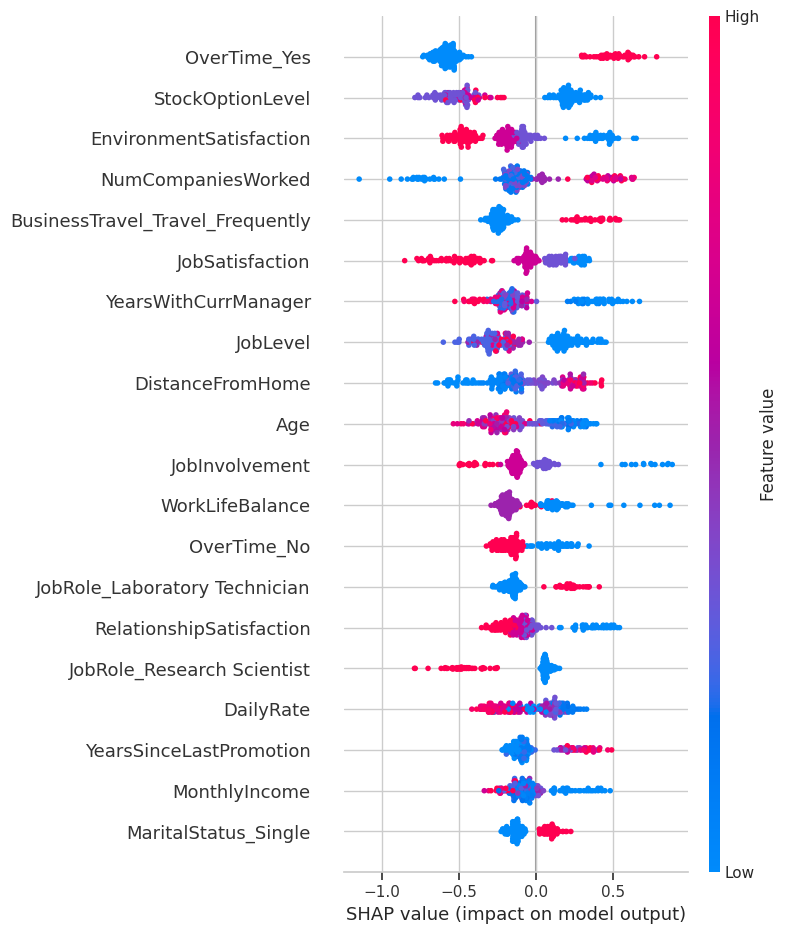

In [48]:
# Use a small sample for SHAP to save time
explainer = shap.Explainer(xgb_clf)
# shap expects original feature names; reconstruct them after one-hot
onehot_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
feature_names = num_features + list(onehot_cols)


X_test_df = pd.DataFrame(X_test_pre, columns=feature_names)


shap_values = explainer(X_test_df.sample(200, random_state=42))


# SHAP summary plot (will open in notebook)
shap.summary_plot(shap_values, X_test_df.sample(200, random_state=42))

In [49]:
# Create a full pipeline (preprocessor + trained model)
final_pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
('classifier', xgb_clf)
])


# Fit pipeline on full train (optional): we already fit model using preprocessed/resampled data
# If you want to retrain final pipeline on the entire training set without SMOTE (or use class_weight), do that here.


joblib.dump(final_pipeline, 'attrition_final_pipeline.joblib')
print('Saved pipeline to attrition_final_pipeline.joblib')

Saved pipeline to attrition_final_pipeline.joblib


In [56]:
import joblib
model = joblib.load('attrition_final_pipeline.joblib')


# Helper function to produce recommendations + prediction
MEDIAN_INCOME = df['MonthlyIncome'].median()


def predict_and_prescribe(record: dict):
    # record: dict of feature values matching original features
    X_ = pd.DataFrame([record])
    proba = model.predict_proba(X_)[0,1]
    pred = int(proba >= 0.5)


    recs = []
    if record.get('OverTime', 'No') == 'Yes' and int(record.get('WorkLifeBalance', 3)) <= 2:
        recs.append('Offer flexible hours or reduce overtime.')
    if record.get('MonthlyIncome', 0) < MEDIAN_INCOME:
        recs.append('Consider salary increment or bonus.')
    if int(record.get('YearsSinceLastPromotion',0)) >= 3:
        recs.append('Review career development / promotion opportunity.')
    if not recs:
        recs = ['No immediate risk. Continue regular engagement.']


    return {'probability': float(proba), 'pred': 'High risk' if pred==1 else 'Low risk', 'recommendations': recs}

In [58]:
# --- Paste this entire cell into Colab and run it ---
!pip install -q gradio

import os, joblib, pandas as pd, gradio as gr

# 1) Try to load df (if you already have df in the session this keeps it)
if 'df' not in globals():
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except Exception:
        pass
    # Change this path if your file is elsewhere
    candidate_path = '/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv'
    if os.path.exists(candidate_path):
        df = pd.read_csv(candidate_path)
        print("Loaded dataset from Drive:", candidate_path)
    else:
        # fallback small sample so the app still works
        print("Dataset not found at", candidate_path, "- using fallback sample for dropdowns")
        df = pd.DataFrame({
            'JobRole': ['Sales Executive','Research Scientist','Manager','Developer'],
            'Department': ['Sales','Research & Development','HR','IT'],
            'MonthlyIncome': [5000,6000,10000,7000]
        })

# 2) Build dropdown options
jobroles = sorted(df['JobRole'].unique())
departments = sorted(df['Department'].unique())

# 3) Try to load a previously saved model (check a few likely filenames)
MODEL_PATHS = [
    'attrition_final_pipeline.joblib',
    'attrition_model_gradio.joblib',
    '/content/attrition_final_pipeline.joblib',
    '/content/attrition_model_gradio.joblib',
    '/content/drive/MyDrive/attrition_final_pipeline.joblib'
]
model = None
for p in MODEL_PATHS:
    if os.path.exists(p):
        try:
            model = joblib.load(p)
            print("Loaded model:", p)
            break
        except Exception as e:
            print("Found model file but failed to load", p, "->", e)

if model is None:
    print("No model loaded — app will use a simple heuristic fallback (so UI still runs).")

# 4) The prediction + prescriptive function (uses loaded model if available)
def predict_and_prescribe(record: dict):
    # record: dict with keys matching the features used in the pipeline
    if model is not None:
        try:
            proba = float(model.predict_proba(pd.DataFrame([record]))[0,1])
            pred = 'High risk' if proba >= 0.5 else 'Low risk'
        except Exception as e:
            # If model fails because of mismatched features, fallback
            print("Model prediction failed:", e)
            model_local = None
            proba = 0.2
            pred = 'Low risk'
    else:
        # Simple heuristic fallback
        proba = 0.8 if record.get('OverTime','No') == 'Yes' and int(record.get('WorkLifeBalance',3)) <= 2 else 0.2
        pred = 'High risk' if proba >= 0.5 else 'Low risk'

    # Recommendations
    recs = []
    MEDIAN_INCOME = df['MonthlyIncome'].median() if 'MonthlyIncome' in df.columns else 5000
    if record.get('OverTime','No') == 'Yes' and int(record.get('WorkLifeBalance',3)) <= 2:
        recs.append("Offer flexible hours or reduce overtime.")
    if float(record.get('MonthlyIncome', 0)) < MEDIAN_INCOME:
        recs.append("Consider salary increment or bonus.")
    if int(record.get('YearsSinceLastPromotion', 0)) >= 3:
        recs.append("Review career development / promotion opportunity.")
    if not recs:
        recs = ["No immediate risk. Continue regular engagement."]
    return {'probability': proba, 'pred': pred, 'recommendations': recs}

# 5) Gradio wrapper (correctly indented)
def gradio_predict(age, monthlyincome, overtime, wlb, years_at_company, years_since_promo, jobrole, department):
    rec = {
        'Age': int(age),
        'MonthlyIncome': float(monthlyincome),
        'OverTime': overtime,
        'WorkLifeBalance': int(wlb),
        'YearsAtCompany': int(years_at_company),
        'YearsSinceLastPromotion': int(years_since_promo),
        'JobRole': jobrole,
        'Department': department
    }
    out = predict_and_prescribe(rec)
    return f"Attrition probability: {out['probability']:.2f} ({out['pred']})", "\n".join(['- ' + r for r in out['recommendations']])

# 6) Build and launch interface
iface = gr.Interface(
    fn=gradio_predict,
    inputs=[
        gr.Number(label='Age', value=30),
        gr.Number(label='Monthly Income', value=5000),
        gr.Radio(['No','Yes'], label='OverTime', value='No'),
        gr.Dropdown([1,2,3,4], label='WorkLifeBalance (1-Bad to 4-Good)', value=3),
        gr.Number(label='Years At Company', value=3),
        gr.Number(label='Years Since Last Promotion', value=1),
        gr.Dropdown(jobroles, label='JobRole'),
        gr.Dropdown(departments, label='Department')
    ],
    outputs=[gr.Textbox(label='Prediction'), gr.Textbox(label='Recommendations')],
    title='Employee Attrition Prediction + Prescriptive Analytics',
    description='Enter employee details to predict attrition probability and HR suggestions.'
)

# Launch: in Colab it's best to use share=True (Colab will print a public URL you can click)
iface.launch(share=True)
# --- end of cell ---


Loaded model: attrition_final_pipeline.joblib
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1efe994a590e56e819.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
